In [133]:
import pandas as pd
import numpy as np
import sys, os
from importlib import reload

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from analysis.evaluator import ModelEvaluator

## Load data and evaluate model

In [134]:
df = pd.read_csv("../data/bank-full.csv", delimiter=';')

In [135]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [136]:
# Convert 'y' to numeric for analysis
df["target"] = np.where(df["y"] == "no", 0, 1)

# Add weights to test weight functionality of plot_target_vs_predictors()
df["weights"] = np.abs(np.random.randn(len(df.index)))

# Add an arbitrary data split for testing functions
df["random"] = np.random.uniform(0, 1, len(df.index))
df["split"] = np.where(df["random"]  > 0.70, "V", "T")

In [137]:
df["split"].value_counts(dropna=False, normalize=True)

split
T    0.698525
V    0.301475
Name: proportion, dtype: float64

In [138]:
df.groupby("split")["target"].mean()

split
T    0.117476
V    0.115847
Name: target, dtype: float64

### Add GLM and GBM predictions for testing functions

In [139]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [140]:
# Split data; define features and target
X = df.drop(columns=["y", "split", "target"])
X_train = df.query("split == 'T'").drop(columns=["y", "split", "target"])
X_test = df.query("split == 'V'").drop(columns=["y", "split", "target"])
y_train = df.query("split == 'T'")["target"]
y_test = df.query("split == 'V'")["target"]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# GLM model
glm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver='liblinear'))
])
glm_pipeline.fit(X_train, y_train)
df["pred_glm"] = glm_pipeline.predict_proba(X)[:, 1]

# XGBoost model
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_pipeline.fit(X_train, y_train)
df["pred_xgb"] = xgb_pipeline.predict_proba(X)[:, 1]


In [141]:
df[["pred_glm", "pred_xgb", "target"]].describe()

,pred_glm,pred_xgb,target
count,45211.000000,45211.000000,45211.000000
mean,0.116917,0.106407,0.116985
std,0.187568,0.219569,0.321406
min,0.000036,0.000001,0.000000
25%,0.020319,0.000966,0.000000
50%,0.043836,0.006956,0.000000
75%,0.108163,0.068118,0.000000
max,1.000000,0.996821,1.000000


## plot_target_vs_predictors function

In [142]:
predictors =  ["job", "balance", "contact", "duration", "marital", "job", "pdays", "previous"]

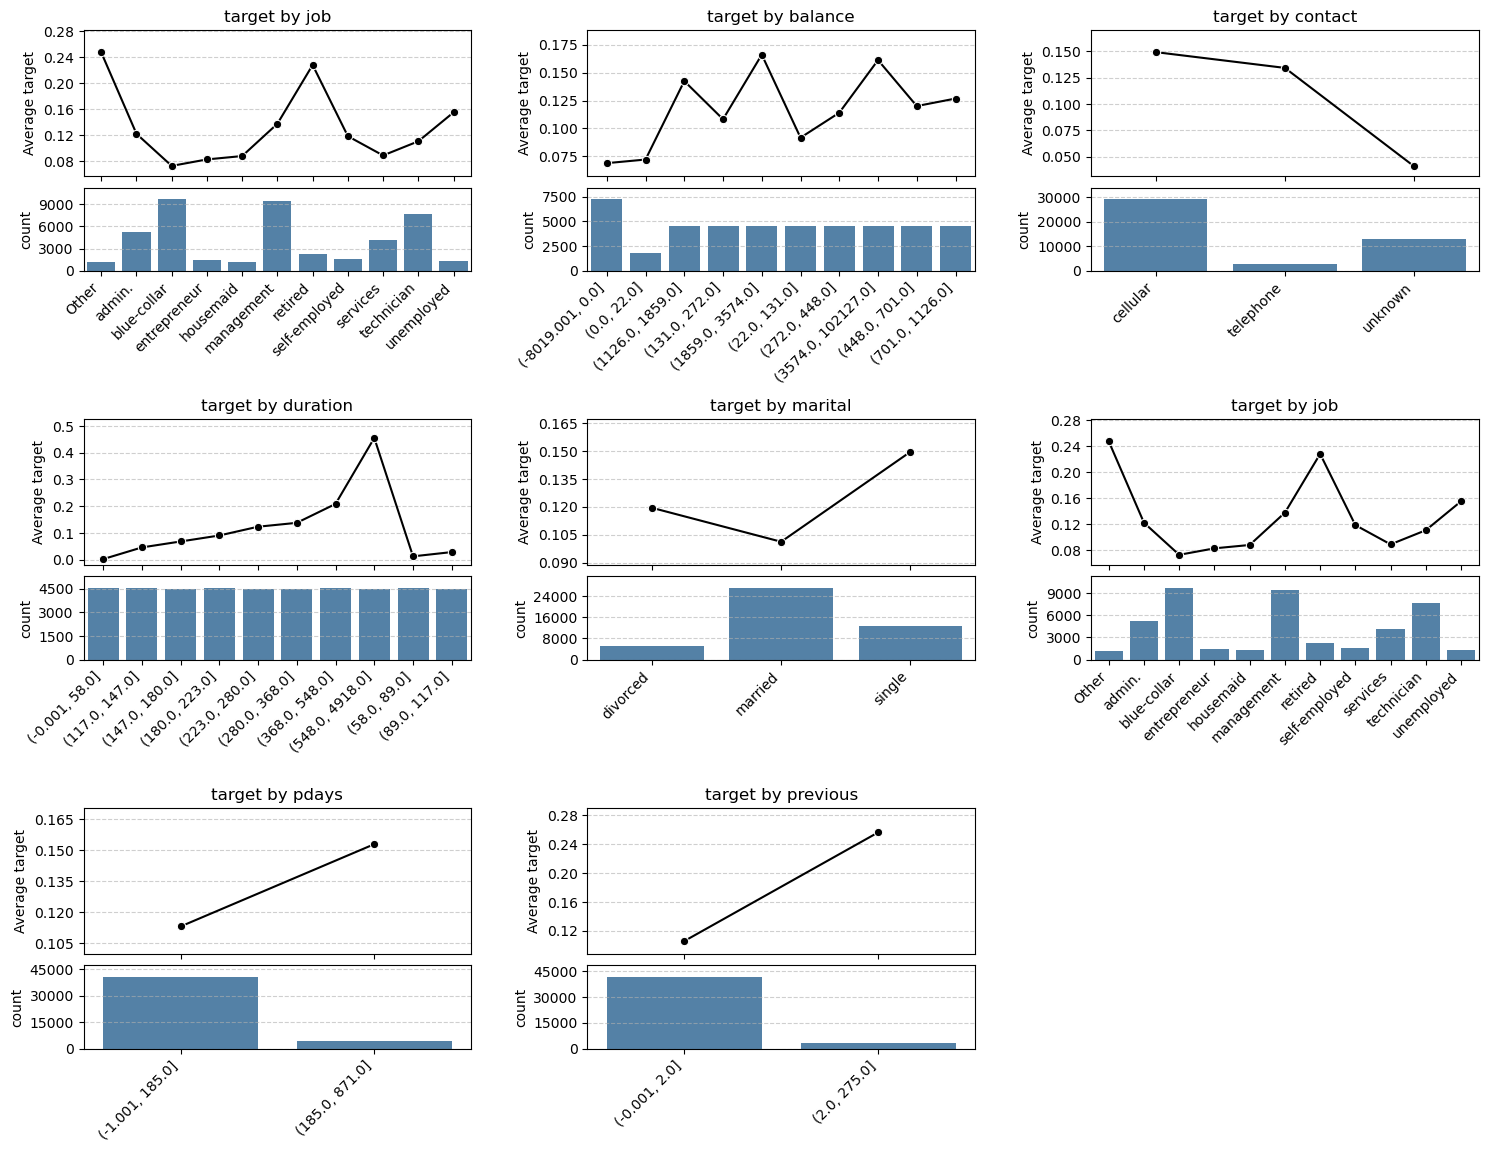

In [143]:
from analysis.plots import plot_target_vs_predictors
plot_target_vs_predictors(df, "target", predictors)

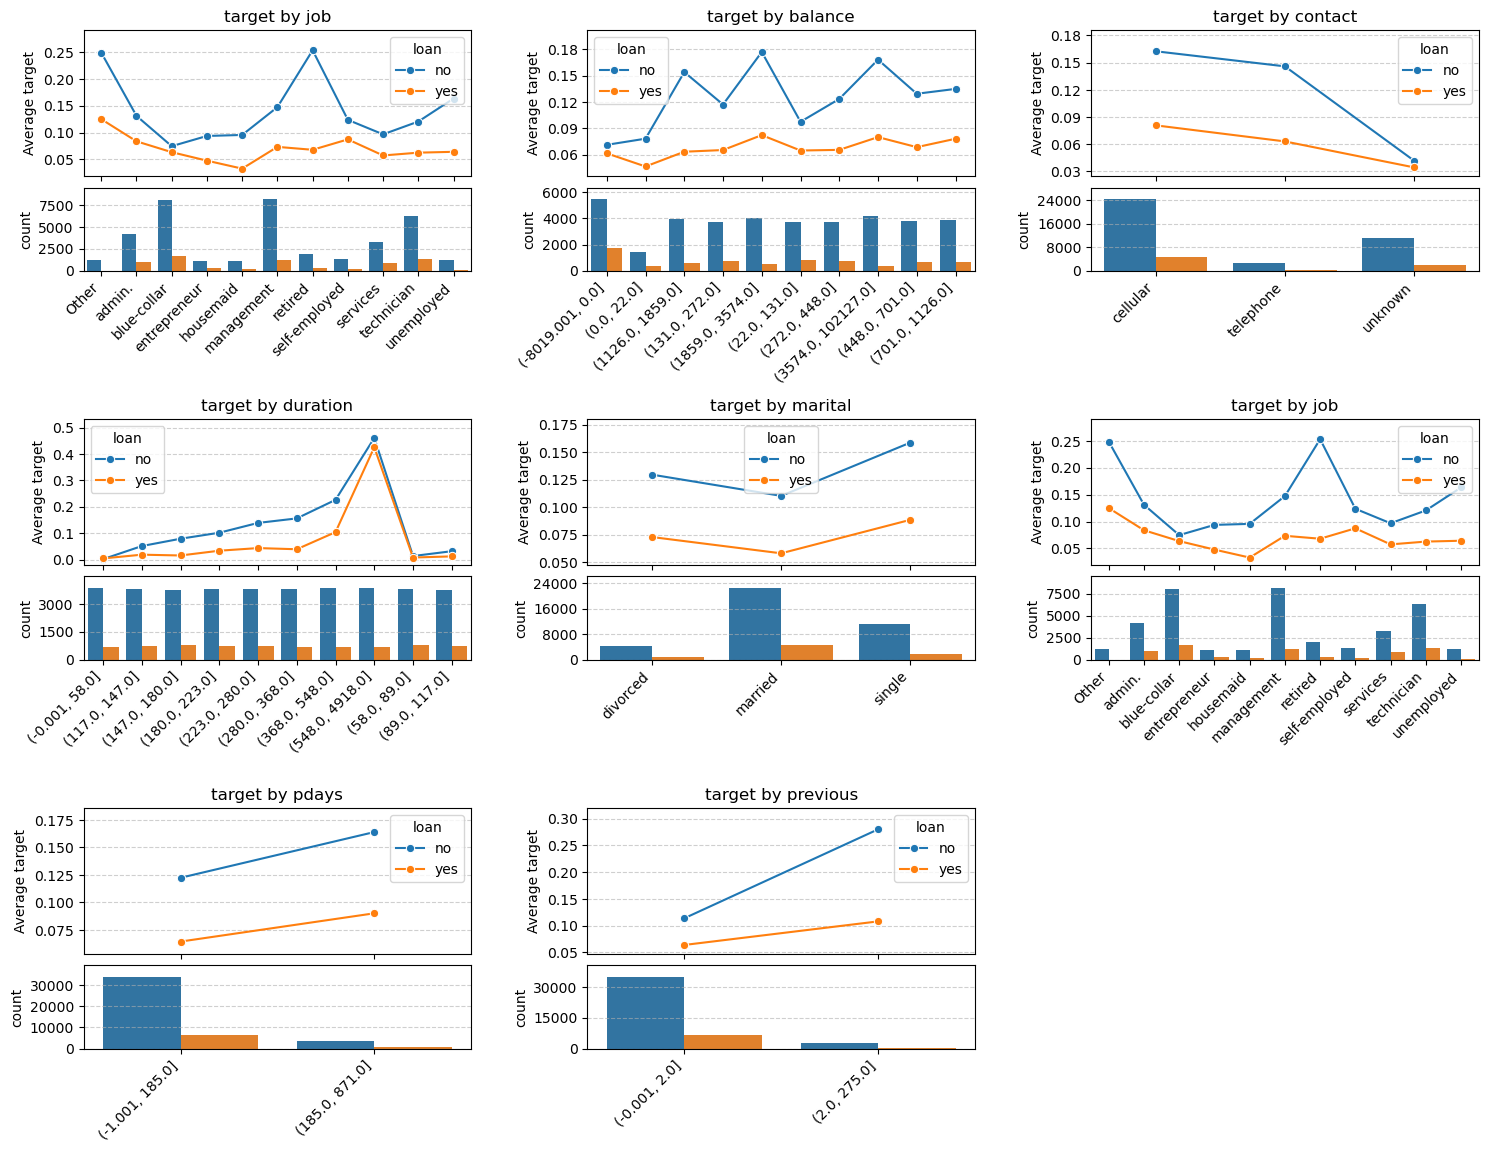

In [144]:
from analysis.plots import plot_target_vs_predictors
plot_target_vs_predictors(df, "target", predictors, group_col="loan");

## Error plots

/home/sagemaker-user/analysis-tools/src/analysis/plots.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.tick_params(axis='x', rotation=45)
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data.groupby("bin")[group_col].mean()
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(group_col_final, observed=False).agg(
/home/sagemaker-user/analysis-tools/src/analysis/plots.

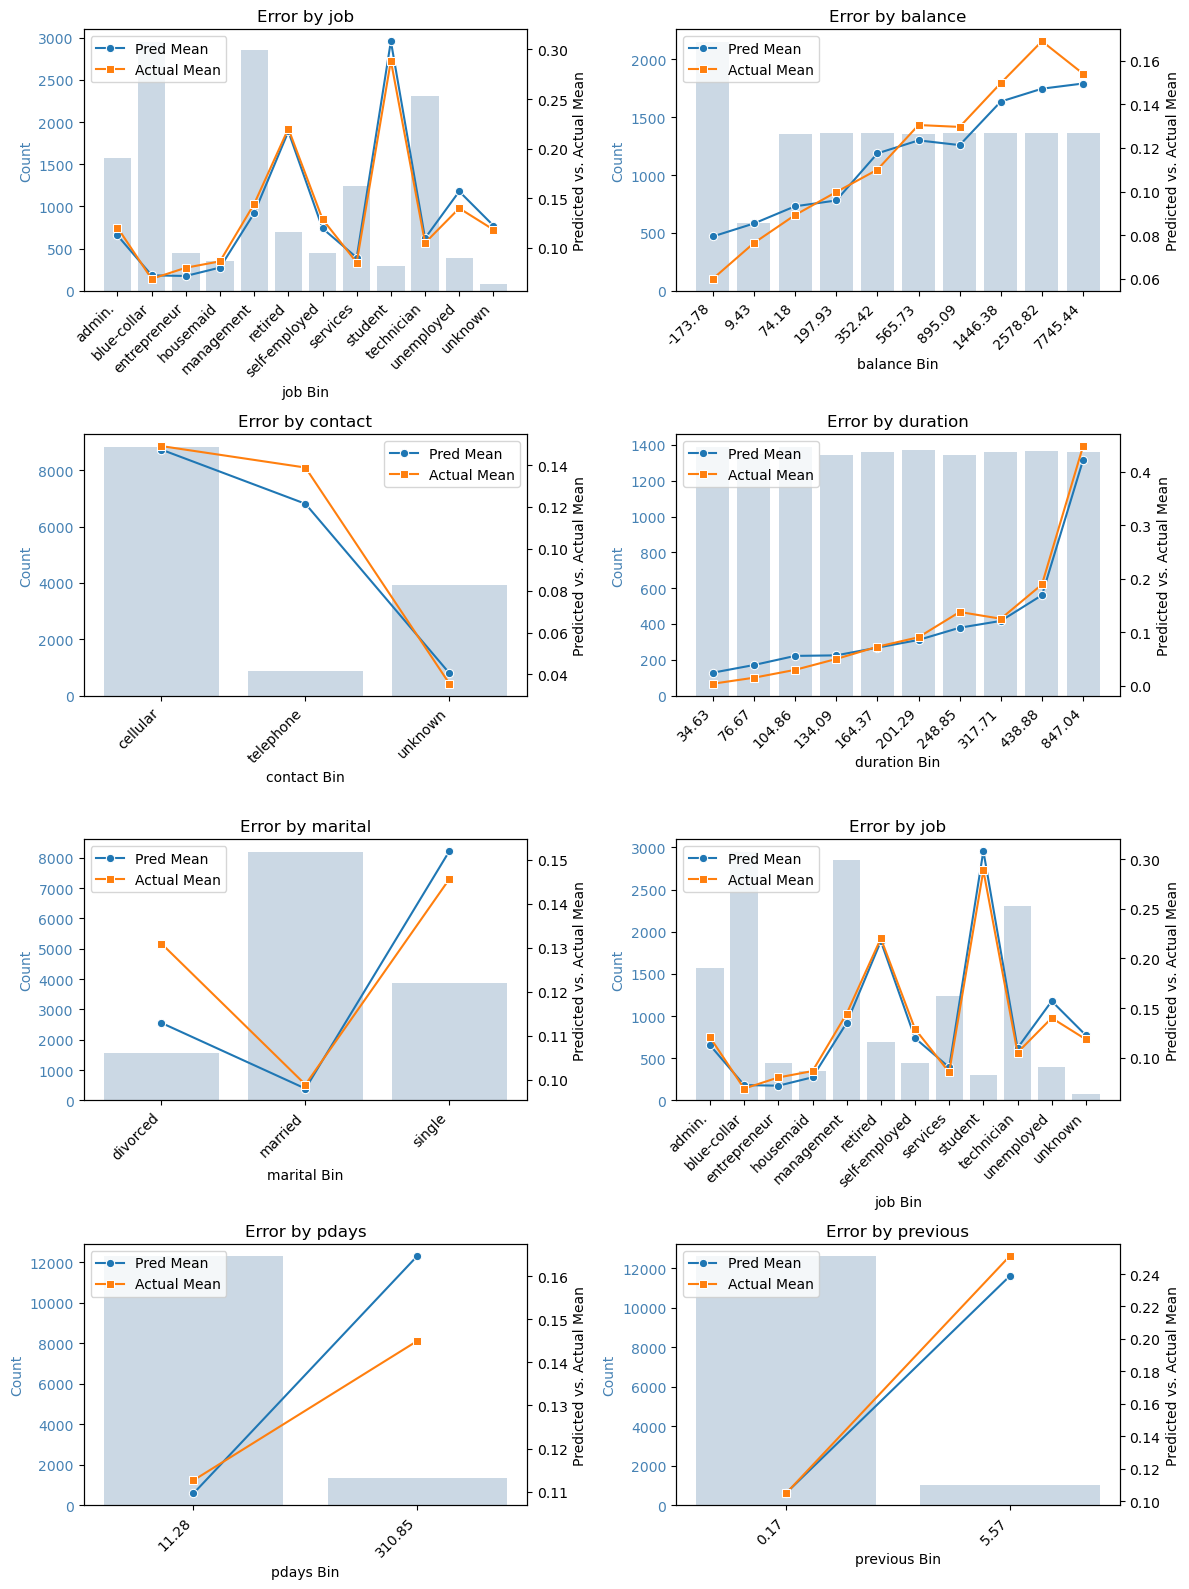

In [145]:
from analysis.plots import plot_error_by_group_grid
plot_error_by_group_grid(
    df.query("split == 'V'"), 
    "target", 
    "pred_glm", 
    predictors, 
    bins=10
    )

/home/sagemaker-user/analysis-tools/src/analysis/plots.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.tick_params(axis='x', rotation=45)
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data.groupby("bin")[group_col].mean()
/home/sagemaker-user/analysis-tools/src/analysis/plots.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(group_col_final, observed=False).agg(
/home/sagemaker-user/analysis-tools/src/analysis/plots.

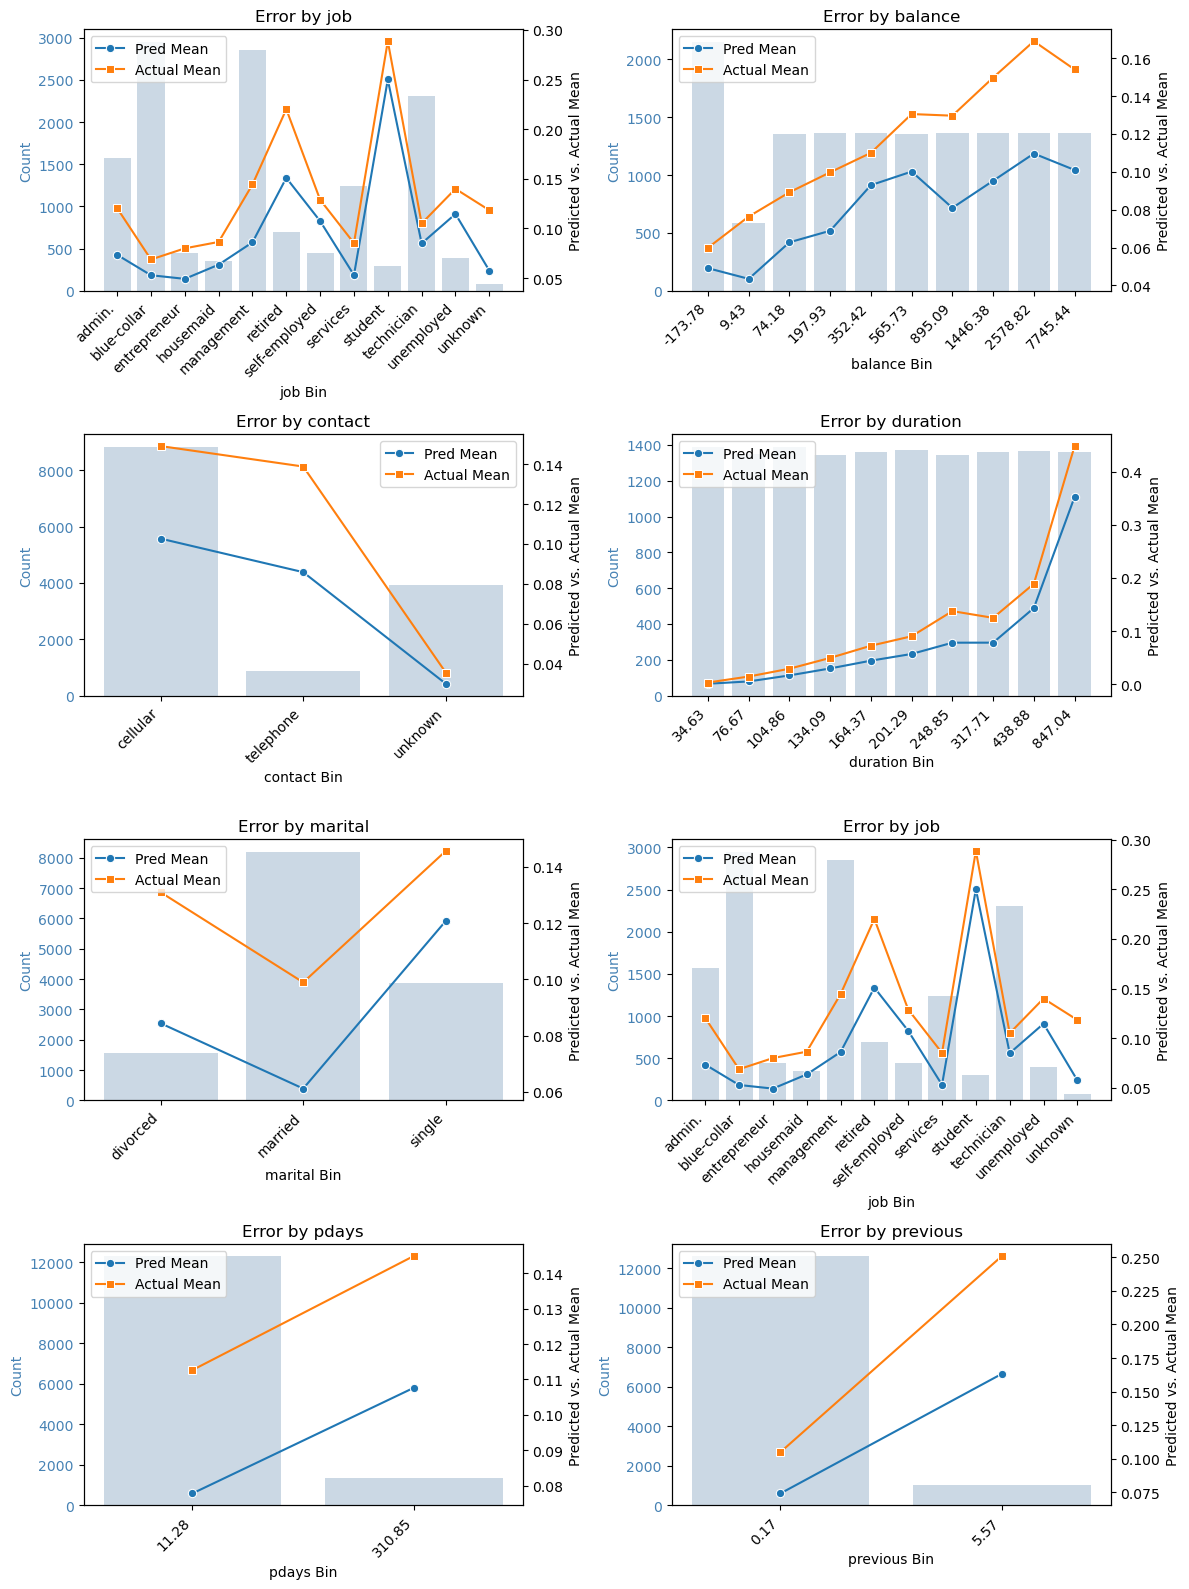

In [146]:
plot_error_by_group_grid(
    df.query("split == 'V'"), 
    "target", 
    "pred_xgb", 
    predictors, 
    bins=10
    )

## Explore creation of tabulation function and object

In [147]:
from analysis.evaluator import ModelEvaluator

In [148]:
me = ModelEvaluator(
        data=df,
        actual_col="target",
        predicted_col="pred_glm",
)

In [149]:
me.compare_models_discrepancy("pred_xgb")

,target,pred_glm,pred_xgb,abs_diff
24174,1,0.008893,0.977000,0.968107
9947,1,0.999995,0.045855,0.954139
24159,1,0.014352,0.966179,0.951827
24182,1,0.008319,0.959501,0.951181
24601,0,0.948466,0.024717,0.923749
44530,1,0.062610,0.976916,0.914307
41893,0,0.995622,0.086754,0.908868
24111,1,0.031209,0.936870,0.905661
41360,1,0.048006,0.950644,0.902638
11216,0,0.974577,0.073075,0.901501


In [150]:
me.export_html("test.html", residual_fit_kwargs={"residual_type": "normalized"})

/home/sagemaker-user/analysis-tools/src/analysis/report.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("bin")
/home/sagemaker-user/analysis-tools/src/analysis/report.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("bin")
/home/sagemaker-user/analysis-tools/src/analysis/report.py:256: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("group")
/home/sagemaker-user/analysis-tools/sr

✅ Analysis report generated at test.html


In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class TailModelEvaluator:
    def __init__(self, y_true, y_pred, pgini_percent=20, cr_percent=10):
        self.y_true = y_true
        self.y_pred = y_pred
        self.pgini_percent = pgini_percent
        self.cr_percent = cr_percent

    def _compute_lorenz_data(self):
        df = pd.DataFrame({'y_true': self.y_true, 'y_pred': self.y_pred})
        df.sort_values('y_pred', ascending=False, inplace=True)
        df['cum_actual'] = df['y_true'].cumsum()
        df['cum_actual_perc'] = df['cum_actual'] / df['y_true'].sum()
        df['population_perc'] = np.arange(1, len(df)+1) / len(df)
        return df

    def _perfect_model_lorenz(self, df):
        total_losses = df['y_true'].sum()
        sorted_losses = np.sort(df['y_true'])[::-1]
        cum_actual = np.cumsum(sorted_losses)
        cum_actual_perc = cum_actual / total_losses
        population_perc = np.arange(1, len(sorted_losses)+1) / len(sorted_losses)
        return population_perc, cum_actual_perc

    def _partial_gini_general(self, population_perc, cum_actual_perc):
        cutoff_x = self.cr_percent / 100
        idx_cutoff = np.searchsorted(population_perc, cutoff_x, side='right')
        pop_cut = population_perc[:idx_cutoff]
        cum_cut = cum_actual_perc[:idx_cutoff]
        if len(pop_cut) == 0 or pop_cut[-1] < cutoff_x:
            pop_cut = np.append(pop_cut, cutoff_x)
            interp_cum = np.interp(cutoff_x, population_perc, cum_actual_perc)
            cum_cut = np.append(cum_cut, interp_cum)
        B = np.trapz(cum_cut, x=pop_cut)
        # corrected equality line area
        A = (cutoff_x**2) / 2
        partial_gini = (B - A) / (1 - A) if A != (1 - A) else 0
        return partial_gini, A, B

    def _capture_ratio(self, df):
        cutoff_idx = int(len(df) * self.cr_percent / 100)
        captured = df.iloc[:cutoff_idx]['y_true'].sum() / df['y_true'].sum()
        return captured

    def plot_metrics(self, num_bins: int = 20):
        df = self._compute_lorenz_data()
        pop_actual = df['population_perc'].values
        cum_actual = df['cum_actual_perc'].values
        pgini, A, B = self._partial_gini_general(pop_actual, cum_actual)

        # perfect model
        pop_perfect, cum_perfect = self._perfect_model_lorenz(df)
        pgini_perfect, A_perfect, B_perfect = self._partial_gini_general(pop_perfect, cum_perfect)

        norm_pgini = pgini / pgini_perfect

        capture_ratio = self._capture_ratio(df)

        # --- Plot Lorenz curve
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(pop_actual*100, cum_actual*100, label='Lorenz Curve')
        ax.plot(pop_perfect*100, cum_perfect*100, 'g--', label='Perfect Model')
        ax.plot([0,100], [0,100], 'k--', alpha=0.7, label='Line of Equality')
        
        # explicit axis vline
        ax.axvline(self.cr_percent, color='r', linestyle='--', label=f'{self.cr_percent}% cutoff')
        
        # fill
        cutoff_idx = np.searchsorted(pop_actual, self.cr_percent/100, side='right')
        ax.fill_between(pop_actual[:cutoff_idx]*100,
                        cum_actual[:cutoff_idx]*100,
                        pop_actual[:cutoff_idx]*100,
                        color='orange', alpha=0.3, label='Partial Gini area')

        ax.set_title(f'Lorenz Curve\nRaw and Normalized Partial Gini at Top {self.pgini_percent}%: {pgini:.3f}, {norm_pgini:.3f})')
        ax.set_xlabel('Cumulative % of Observations')
        ax.set_ylabel('Cumulative % of Actuals')
        ax.legend()
        ax.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax.set_xticks(np.arange(0, 110, 10))
        ax.set_yticks(np.arange(0, 110, 10))
        plt.show()

        # --- Binned calibration / lift plot
        df_binned = df.copy()
        df_binned.sort_values('y_pred', inplace=True)  # ascending for calibration plot
        df_binned['bin'], bins = pd.qcut(df_binned['y_pred'], q=num_bins, retbins=True, labels=False, duplicates='drop')
        bin_avg_pred = df_binned.groupby('bin')['y_pred'].mean()
        bin_avg_actual = df_binned.groupby('bin')['y_true'].mean()
    
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(bin_avg_pred.values, label='Avg Prediction', marker='o')
        ax.plot(bin_avg_actual.values, label='Avg Actual', marker='x')
        ax.set_title(f'Lift Chart ({num_bins} bins)')
        ax.set_xlabel(f'{num_bins} Bins (Low to High Prediction)')
        ax.set_ylabel('Average Target per Bin')
        ax.grid(True, which='both', linestyle=':', linewidth=0.5)
    
        # # vertical line for top X% (calculate bin index)
        # bin_for_capture = int((self.cr_percent / 100) * num_bins)
        # ax.axvline(bin_for_capture, color='g', linestyle='--', label=f'Top {self.cr_percent}% cutoff')
    
        ax.legend()
        plt.show()
    
    def save_html(self, output_path="output.html", num_bins: int = 20):
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
    
        df = self._compute_lorenz_data()
        pop_actual = df['population_perc'].values
        cum_actual = df['cum_actual_perc'].values
        pgini, A, B = self._partial_gini_general(pop_actual, cum_actual)
    
        pop_perfect, cum_perfect = self._perfect_model_lorenz(df)
        pgini_perfect, A_perfect, B_perfect = self._partial_gini_general(pop_perfect, cum_perfect)
    
        norm_pgini = pgini / pgini_perfect if pgini_perfect != 0 else 0
    
        capture_ratio = self._capture_ratio(df)
    
        # Binned calibration / lift data
        df_binned = df.copy()
        df_binned.sort_values('y_pred', inplace=True)
        df_binned['bin'], bins = pd.qcut(df_binned['y_pred'], q=num_bins, retbins=True, labels=False, duplicates='drop')
        bin_avg_pred = df_binned.groupby('bin')['y_pred'].mean()
        bin_avg_actual = df_binned.groupby('bin')['y_true'].mean()
    
        bin_for_capture = int((self.cr_percent / 100) * num_bins)
    
        # Build plotly subplots
        fig = make_subplots(rows=1, cols=2, subplot_titles=(
            f"Lorenz Curve<br>Raw and Normalized Gini at Top {self.pgini_percent}%: {pgini:.3f}, {norm_pgini:.3f}",
            f"Lift Chart ({num_bins} bins)"
        ))
    
        # Lorenz curve
        fig.add_trace(go.Scatter(
            x=pop_actual*100, y=cum_actual*100,
            mode='lines', name='Lorenz Curve'
        ), row=1, col=1)
        fig.add_trace(go.Scatter(
            x=pop_perfect*100, y=cum_perfect*100,
            mode='lines', line=dict(dash='dot', color='green'),
            name='Perfect Model'
        ), row=1, col=1)
        fig.add_trace(go.Scatter(
            x=[0,100], y=[0,100],
            mode='lines', line=dict(dash='dash', color='black'),
            showlegend=False
        ), row=1, col=1)
        fig.add_vline(x=self.pgini_percent, line_dash='dash', line_color='red', row=1, col=1)
    
        # shaded partial Gini area
        cutoff_idx = np.searchsorted(pop_actual, self.pgini_percent/100, side='right')
        fig.add_trace(go.Scatter(
            x=np.concatenate([pop_actual[:cutoff_idx]*100, (pop_actual[:cutoff_idx][::-1]*100)]),
            y=np.concatenate([cum_actual[:cutoff_idx]*100, pop_actual[:cutoff_idx][::-1]*100]),
            fill='toself',
            fillcolor='rgba(255,165,0,0.3)',
            line=dict(color='rgba(255,165,0,0)'),
            showlegend=True,
            name='Partial Gini Area'
        ), row=1, col=1)
    
        # Lift / binned calibration
        fig.add_trace(go.Scatter(
            x=list(range(len(bin_avg_pred))), y=bin_avg_pred.values,
            mode='lines+markers', name='Avg Prediction'
        ), row=1, col=2)
        fig.add_trace(go.Scatter(
            x=list(range(len(bin_avg_actual))), y=bin_avg_actual.values,
            mode='lines+markers', name='Avg Actual'
        ), row=1, col=2)
        # fig.add_vline(x=bin_for_capture, line_dash='dash', line_color='green', row=1, col=2)
    
        # Formatting
        fig.update_xaxes(title='% of Policies', range=[0,100], dtick=10, row=1, col=1)
        fig.update_yaxes(title='% of Total Losses', range=[0,100], dtick=10, row=1, col=1)
    
        fig.update_xaxes(title=f'{num_bins} Bins (Low to High Prediction)', row=1, col=2)
        fig.update_yaxes(title='Average Target per Bin', row=1, col=2)
    
        fig.update_layout(
            # title=f"Partial Gini, Normalized Partial Gini, and Lift ({self.pgini_percent}% cutoff)",
            showlegend=True
        )
    
        fig.write_html(output_path)
        print(f"Saved interactive plots to {output_path}")



In [203]:
tme = TailModelEvaluator(df["target"], df["pred_glm"], cr_percent=70)

# self.y_true = y_true
# self.y_pred = y_pred
# self.pgini_percent = pgini_percent
# self.cr_percent = cr_percent

In [204]:
tme.save_html()

Saved interactive plots to output.html
